# Step 03 - Testing: Ensure that holdout data can flow through the trained model as expected

Notebook is built to retrieve and download a MLflow model from a AML registry (however, this could be from any registry), then to create a serving docker image based on the included `Dockerfile` here. The dependencies contained within the MLflow's conda YAML file are installed into that image before it is pushed into a container registry.

In [1]:
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, Environment, ModelPackage, BaseEnvironment, AzureMLOnlineInferencingServer, CodeConfiguration, DataCollector, DeploymentCollection
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import mlflow
import mlflow.xgboost


model = mlflow.xgboost.load_model('model')
model

XGBRegressor(base_score='3.301454E4', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [3]:
import pandas as pd
from mltable import from_delta_lake
mltable_ts = from_delta_lake(delta_table_uri="azureml://subscriptions/<SUB>/resourcegroups/<RG>/workspaces/<WORKSPACE>/datastores/<DATASTORE>/paths/<PATH>/")
df = mltable_ts.to_pandas_dataframe()
df

,DateTime,Temperature,Humidity,Wind-Speed,general-diffuse-flows,diffuse-flows,Zone-1-Power-Consumption,Zone-2--Power-Consumption,Zone-3--Power-Consumption
0,2017-10-01 00:00:00,18.120,87.6,4.916,0.080,0.163,31755.62363,17985.06224,14898.96657
1,2017-10-01 00:10:00,18.000,88.5,4.916,0.055,0.137,31175.84245,17611.61826,14531.30699
2,2017-10-01 00:20:00,18.010,88.4,4.916,0.069,0.148,30154.92341,17148.54772,14321.21581
3,2017-10-01 00:30:00,18.160,88.4,4.914,0.062,0.167,29764.20131,16827.38589,14198.66261
4,2017-10-01 00:40:00,18.180,89.1,4.917,0.051,0.115,29600.35011,16621.99170,13889.36170
...,...,...,...,...,...,...,...,...,...
13099,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
13100,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
13101,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
13102,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [5]:
zone_cols = [x for x in df.columns if 'Zone' in x]
actuals = df['Zone-1-Power-Consumption']
X = df.drop(columns=zone_cols)  # Drop the target column
X = X.drop(columns=['DateTime'])

X

,Temperature,Humidity,Wind-Speed,general-diffuse-flows,diffuse-flows
0,18.120,87.6,4.916,0.080,0.163
1,18.000,88.5,4.916,0.055,0.137
2,18.010,88.4,4.916,0.069,0.148
3,18.160,88.4,4.914,0.062,0.167
4,18.180,89.1,4.917,0.051,0.115
...,...,...,...,...,...
13099,7.010,72.4,0.080,0.040,0.096
13100,6.947,72.6,0.082,0.051,0.093
13101,6.900,72.8,0.086,0.084,0.074
13102,6.758,73.0,0.080,0.066,0.089


In [7]:
preds = model.predict(X)

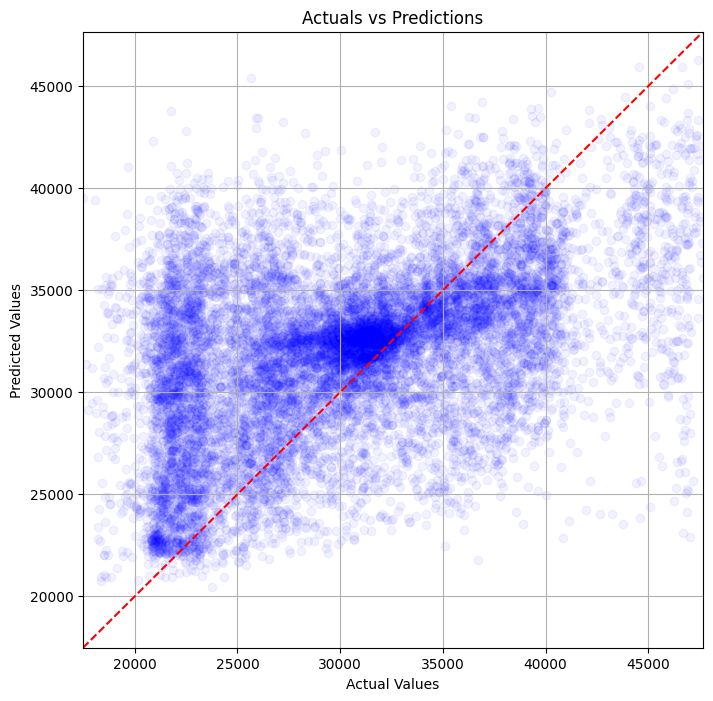

In [12]:
import matplotlib.pyplot as plt

def plot_actuals_vs_predictions(actuals, predictions, title="Actuals vs Predictions", xlabel="Actual Values", ylabel="Predicted Values"):
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, color='blue', alpha=0.05)
    
    # Plotting a diagonal line for reference (perfect prediction)
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])
    
    plt.grid(True)
    plt.show()
    
plot_actuals_vs_predictions(actuals, preds)

In [15]:
out_str = X.head(10).to_json(orient='records')
out_str

'[{"Temperature":18.12,"Humidity":87.6,"Wind-Speed":4.916,"general-diffuse-flows":0.08,"diffuse-flows":0.163},{"Temperature":18.0,"Humidity":88.5,"Wind-Speed":4.916,"general-diffuse-flows":0.055,"diffuse-flows":0.137},{"Temperature":18.01,"Humidity":88.4,"Wind-Speed":4.916,"general-diffuse-flows":0.069,"diffuse-flows":0.148},{"Temperature":18.16,"Humidity":88.4,"Wind-Speed":4.914,"general-diffuse-flows":0.062,"diffuse-flows":0.167},{"Temperature":18.18,"Humidity":89.1,"Wind-Speed":4.917,"general-diffuse-flows":0.051,"diffuse-flows":0.115},{"Temperature":18.29,"Humidity":89.0,"Wind-Speed":4.919,"general-diffuse-flows":0.062,"diffuse-flows":0.133},{"Temperature":18.59,"Humidity":89.2,"Wind-Speed":4.913,"general-diffuse-flows":0.069,"diffuse-flows":0.119},{"Temperature":18.75,"Humidity":88.9,"Wind-Speed":4.916,"general-diffuse-flows":0.073,"diffuse-flows":0.096},{"Temperature":18.61,"Humidity":88.8,"Wind-Speed":4.917,"general-diffuse-flows":0.048,"diffuse-flows":0.063},{"Temperature":18.7

In [17]:
import json
df2 = pd.DataFrame(json.loads(out_str))

model.predict(df2)

array([25861.084, 26112.803, 25335.572, 25796.871, 27547.596, 30288.672,
       25749.523, 27357.117, 29302.332, 26473.824], dtype=float32)